In [1]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle

%matplotlib inline

In [2]:
X_train = idx2numpy.convert_from_file("./train-images.idx3-ubyte")
X_test = idx2numpy.convert_from_file("./t10k-images.idx3-ubyte")
y_train = idx2numpy.convert_from_file("./train-labels.idx1-ubyte")
y_test = idx2numpy.convert_from_file("./t10k-labels.idx1-ubyte")

In [3]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [2]:
def display(img):
    image_width = image_height = np.ceil(np.sqrt(img.shape[0])).astype(np.uint8)
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

In [3]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [6]:
labels_count = np.unique(y_train).shape[0]
y_train = dense_to_one_hot(y_train, labels_count)
y_test = dense_to_one_hot(y_test, labels_count)

In [4]:
class mlp_NN():
    func_set = ["Sigmoid", "Tanh", "ReLU", "ExpLin", "Softmax", "Linear"]
    loss_func_set = ['mse', 'cross-entropy']
    
    # Activation functions
    def sigmoid(self, z, deriv=False):
        z = np.maximum(-30, z)
        z = np.minimum(30, z)
        if deriv == False:
            return 1.0/(1.0 + np.exp(-z))
        else:
            return self.sigmoid_deriv(z)
    
    def sigmoid_deriv(self, z):
        return self.sigmoid(z) * (1-self.sigmoid(z))
    def tanh(self, z, deriv = False):
        if deriv == False:
            return np.tanh(z)
        else:
            return self.tanh_deriv(z)
        
    def tanh_deriv(self, z):
        return 1.0 - np.pow(self.tanh(z), 2)
    def rectifier(self, z, deriv = False):
        if deriv == False:
            return max(0,z)
        else:
            return 0 + (z>0)
    def explin(self, z, deriv = False):
        if deriv == False:
            return (z>0)*z + (z<=0)*(np.exp(z) - 1)
        else:
            return (z>0)*1 + (z<=0)*(np.exp(z))
        
    # Output functions    
    def linear(self, z, deriv = False):
        if deriv == False:
            return z
        else:
            return 1
        
    def softmax(self, z, deriv = False):
        if deriv == False:
            s = np.max(z, axis = 1)
            s = s[:, np.newaxis]
            e_x = np.exp(z - s)
            div = np.sum(e_x, axis = 1)
            div = div[:, np.newaxis]
            return e_x / div
        else:
            s = np.max(z, axis = 1)
            s = s[:, np.newaxis]
            e_x = np.exp(z - s)
            div = np.sum(e_x, axis = 1)
            div = div[:, np.newaxis]
            
            return e_x / div - e_x / (div)**2
    
    # Loss functions
    def mse(self, y_pred, y_true, deriv = False):
        return np.sum(np.average((y_pred - y_true)**2, axis = 0))
    def nll(self, y_pred, y_true, deriv = False):
        eps = 1e-4
        y_pred = np.maximum(eps, y_pred)
        y_pred = np.minimum(1-eps, y_pred)
        #actual = np.zeros(y_pred.shape)
        rows = y_pred.shape[0]
        #actual[np.arange(rows), np.argmax(y_true.astype(int))] = 1
        #print actual
        #vsota = actual * np.log(y_pred)
        return -1.0 / rows * np.sum(np.log(y_pred) * y_true)
    
    def act_function(self, function, mbatch, deriv = False):
        if function == 'Sigmoid':
            return self.sigmoid(mbatch, deriv)
        elif function == 'Tanh':
            return self.tanh(mbatch, deriv)
        elif function == 'ReLU':
            return self.rectifier(mbatch, deriv)
        elif function == 'ExpLin':
            return self.explin(mbatch, deriv)
        elif function == 'Linear':
            return self.linear(mbatch, deriv)
        elif function == 'Softmax':
            return self.softmax(mbatch, deriv)
        
    def loss_function(self, X, y):
        if self.loss == 'mse':
            return self.mse(X, y)
        elif self.loss == 'cross-entropy':
            return self.nll(X, y)
        
    def add_bias(self, X, bias):
        if bias == True:
            return np.concatenate((np.ones((X.shape[0],1)), X), 1)
        else:
            return X
        
    def regul(self, w):
        if self.penalty == 'L1':
            return np.abs(self.C*w)
        elif self.penalty == 'L2':
            return self.C*np.power(w, 2)/2.0
        
    def regul_deriv(self, w):
        if self.penalty == 'L1':
            return np.sign(self.C*w)
        elif self.penalty == 'L2':
            return self.C*w
        
    
    def __init__(self, layers, bias_input = False, batch_size = 0, verbose = False, learning_rate = 1.0,
                 n_iter = 1000, loss = 'NLL', penalty = 'L2', C = 1.0):
        """
        layers - list of ('Sigmoid', 10, bias = False)-like tuples
        verbose - gradient change printing
        learning_rate - multiplier of gradient change
        n_iter = number of iterations
        loss - loss function
        """
        self.ready = True
        self.bias_input = bias_input
        self.batch_size = batch_size
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.loss = loss
        self.layers = layers
        self.weights = []
        self.biases = []
        self.outputs = [0]*(len(layers)+1)
        self.inputs = [0]*(len(layers)+1)
        self.errors = [0]*(len(layers)+1)
        self.penalty = penalty
        self.C = C
        self.errors_plot = []
        if len(self.layers) == 0:
            print "There must be at least output layer"
            self.ready = False#
        else:
            for num, layer in enumerate(self.layers):
                if layer[0] not in self.func_set and num != len(self.layers) - 1:
                    print "Layer must be from set ", self.func_set
                    self.ready = False
    
    def fit(self, X, y):
        if not self.ready:
            print "Network isn't ready."
        else:
            if self.batch_size == 0:
                self.batch_size = X.shape[0] + 1
            current_layer_size = X.shape[1]
            for num, layer in enumerate(self.layers):
                if num == len(self.layers) - 1:
                    self.weights.append(np.random.rand(current_layer_size, y.shape[1])-0.5)#/ np.sqrt(current_layer_size))
                    self.biases.append(np.random.rand(1, y.shape[1])-0.5)
                else:
                    if layer[2] == True: # bias
                        self.weights.append(np.random.rand(current_layer_size, layer[1])-0.5)#/ np.sqrt(current_layer_size))
                        current_layer_size = layer[1]
                    else: # no bias
                        self.weights.append(np.random.rand(current_layer_size, layer[1])-0.5)#/ np.sqrt(current_layer_size))
                        current_layer_size = layer[1]
                    self.biases.append(np.random.rand(1, current_layer_size)-0.5)

            # Fitting
            epoch = 0
            while epoch < self.n_iter:
                # Feed-forward
                X, y = shuffle(X, y)
                mini_batch = X[:self.batch_size]
                y_mini_batch = y[:self.batch_size]
                self.outputs[0] = mini_batch
                for num, layer in enumerate(self.layers):
                    self.inputs[num+1] = np.dot(self.outputs[num], self.weights[num])
                    # print 'Inputs', num, self.inputs[num+1]
                    output_temp = self.act_function(layer[0], self.inputs[num+1] + self.biases[num])
                    if num != len(self.layers) - 1:
                        self.outputs[num+1] = output_temp
                    else:
                        self.outputs[num+1] = output_temp
                    # print 'Output', num+1, output_temp
                    # self.weights[num] = self.weights[num]
                    
                # Counting loss
                error = self.loss_function(self.outputs[len(self.layers)], y_mini_batch)# + self.regul(self.penalty, self.C)
                self.errors_plot.append(error)
                # Backprogapation
                self.errors[len(self.layers)] = np.subtract(self.outputs[len(self.layers)], y_mini_batch)
                # self.errors[len(self.layers)] = self.errors[len(self.layers)] * self.act_function(self.layers[len(self.layers)-1][0], self.inputs[len(self.layers)], deriv = True)
                for i in range(len(self.layers) - 1, 0, -1):
                    self.errors[i] = np.dot(self.errors[i+1], self.weights[i].T + self.regul_deriv(self.weights[i].T))
                    grad_plus = np.dot(self.errors[i+1], self.weights[i].T + 1e-4+ self.regul_deriv(self.weights[i].T))
                    grad_minus = np.dot(self.errors[i+1], self.weights[i].T - 1e-4 + self.regul_deriv(self.weights[i].T))
                    
                    self.errors[i] = self.errors[i] * self.act_function(self.layers[i][0], self.outputs[i], deriv = True)
                    grad_plus = grad_plus * self.act_function(self.layers[i][0], self.outputs[i], deriv = True)
                    grad_minus = grad_minus * self.act_function(self.layers[i][0], self.outputs[i], deriv = True)
                    
                    grad2 = np.dot(self.outputs[i-1].T, self.errors[i]) / self.batch_size
                    # print np.average((np.dot(self.outputs[i-1].T, grad_plus) - np.dot(self.outputs[i-1].T, grad_minus))/(self.batch_size*2e-4) - grad2)
                for i in range(0, len(self.layers) - 1):
                    grad = np.dot(self.outputs[i].T, self.errors[i+1]) / self.batch_size
                    if self.layers[i][2] == True:
                        self.weights[i] = self.weights[i] - self.learning_rate * grad
                        self.biases[i] = self.biases[i] - self.learning_rate * self.errors[i] / self.batch_size
                    else:
                        self.weights[i] = self.weights[i] - self.learning_rate * grad
                        self.biases[i] = self.biases[i] - self.learning_rate * self.errors[i] / self.batch_size
                        
                
                if epoch % 10 == 0 and epoch > 0:
                    print 'Epoch', epoch, '\tloss:', error
                    #self.learning_rate /= 2.0
                epoch += 1
                # self.learning_rate *= 0.75
        
    def predict(self, X):
        for num, layer in enumerate(self.layers):
            X = np.dot(X, self.weights[num])
            X = self.act_function(layer[0], X + self.biases[num])
        return X

In [113]:
testnn = mlp_NN(bias_input = True, batch_size = 300, learning_rate = 0.3, n_iter = 450, loss = 'cross-entropy', penalty = 'L2',
                C = 0.0003,
                layers = [('Sigmoid', 200, True),
                          ('Softmax', )],
                verbose = False)

In [5]:
def test_accuracy(y_pred, y_true):
    return np.sum((np.array(y_pred) == np.array(y_true))) / float(np.array(y_pred).shape[0])

In [114]:
testnn.fit(X_train, y_train)

Epoch 10 	loss: 1.01875298918
Epoch 20 	loss: 0.639233334128
Epoch 30 	loss: 0.637206396782
Epoch 40 	loss: 0.57112221905
Epoch 50 	loss: 0.597817762698
Epoch 60 	loss: 0.471091409847
Epoch 70 	loss: 0.569756751594
Epoch 80 	loss: 0.470657731138
Epoch 90 	loss: 0.428702579013
Epoch 100 	loss: 0.521210350286
Epoch 110 	loss: 0.509106705227
Epoch 120 	loss: 0.499950005801
Epoch 130 	loss: 0.33326745897
Epoch 140 	loss: 0.396816354287
Epoch 150 	loss: 0.375313407718
Epoch 160 	loss: 0.426289538082
Epoch 170 	loss: 0.441529122964
Epoch 180 	loss: 0.393846038397
Epoch 190 	loss: 0.405633574785
Epoch 200 	loss: 0.432093731005
Epoch 210 	loss: 0.333210147878
Epoch 220 	loss: 0.426692751609
Epoch 230 	loss: 0.32891718793
Epoch 240 	loss: 0.386644700125
Epoch 250 	loss: 0.406195552059
Epoch 260 	loss: 0.326385188651
Epoch 270 	loss: 0.288383808313
Epoch 280 	loss: 0.413749264248
Epoch 290 	loss: 0.399424322488
Epoch 300 	loss: 0.414347471499
Epoch 310 	loss: 0.450648433811
Epoch 320 	loss: 0.34

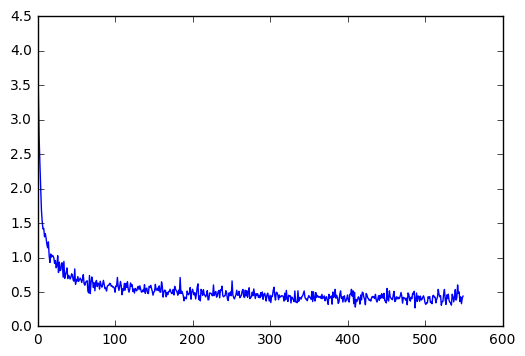

In [94]:
plt.plot(testnn.errors_plot)

In [115]:
test_accuracy(np.argmax(testnn.predict(X_test), axis = 1), np.argmax(y_test, axis = 1))

0.89949999999999997

# Sanity check

XOR

In [6]:
size_Train = 1000
XOR_original = np.array(np.random.randint(0,2, size = (size_Train,2)), dtype='float')
y_xor_train = np.array([int(n[0] != n[1]) for n in XOR_original])
y_xor_train = np.array([[0,1] if n == 1 else [1,0] for n in y_xor_train])
XOR_original += (np.random.random_sample((size_Train, 2)) - 0.5)*0.5

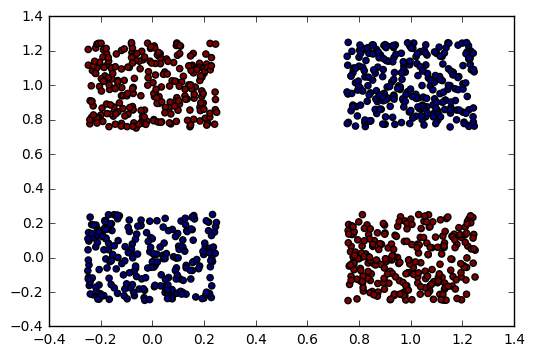

In [7]:
plt.scatter(XOR_original[:,0], XOR_original[:,1], c=np.argmax(y_xor_train, axis = 1))

In [8]:
size_test = 500
XOR_test = np.array(np.random.randint(0,2, size = (size_test,2)), dtype='float')
y_xor_test = np.array([int(n[0] != n[1]) for n in XOR_test])
y_xor_test = np.array([[0,1] if n == 1 else [1,0] for n in y_xor_test])
XOR_test += (np.random.random_sample((size_test, 2)) - 0.5)*0.5

In [13]:
xornn = mlp_NN(bias_input = True, batch_size = 0, learning_rate = 1.0, n_iter = 40, loss = 'cross-entropy', penalty = 'L2',
               C = 1e-1,
                layers = [('Sigmoid', 3, True),
                          ('Softmax', )],
                verbose = False)

In [14]:
xornn.fit(XOR_original, y_xor_train)

Epoch 10 	loss: 0.82191425102
Epoch 20 	loss: 0.815869752233
Epoch 30 	loss: 0.81014185784


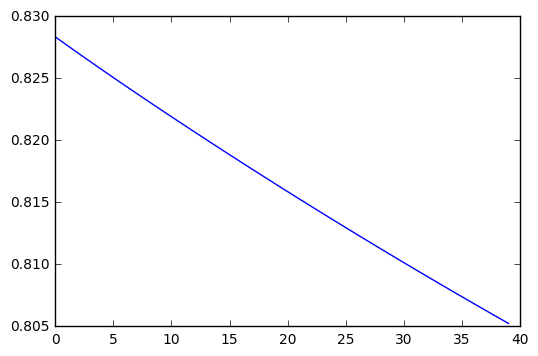

In [15]:
plt.plot(xornn.errors_plot)

In [16]:
test_accuracy(np.argmax(xornn.predict(XOR_test), axis = 1), np.argmax(y_xor_test, axis=1))

0.47399999999999998